In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import matthews_corrcoef, balanced_accuracy_score, make_scorer
from imblearn.over_sampling import RandomOverSampler
import sys
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/gdrive')
    file_path = "/content/gdrive/MyDrive/Colab Notebooks/hydrogenase/"
else:
    file_path = "./"

%matplotlib inline

Mounted at /content/gdrive


In [ ]:
data = pd.read_csv(file_path+'Df-H2ase-CO.csv')
data.shape

(825, 808)

In [ ]:
# Split the data into features (X) and target variable (y)
X = data.drop(columns=["Binary","Trajectory", "Frame", "Pathway-new"])  # Features
y = data['Pathway-new']  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)
X_train.shape, X_test.shape

((577, 804), (248, 804))

In [ ]:
oversampler = RandomOverSampler(random_state=1)

# Resample the training data
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=500, oob_score=True, random_state=1)
param_grid = {
    'max_depth': [10, 12, 15, 20, None],
    'ccp_alpha': [0, 0.0004, 0.0005, 0.0007, 0.001],
    'max_samples': [0.7, 0.8, 0.9, 0.95]
}

scoring = {
    'BA': make_scorer(balanced_accuracy_score),
    'MCC': make_scorer(matthews_corrcoef)
}

grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring=scoring, refit='BA')
grid_search.fit(X_train_resampled, y_train_resampled)
cv_results = grid_search.cv_results_

print("\nBest Parameters:")
print(grid_search.best_params_)

mean_test_ba = cv_results['mean_test_BA']
std_test_ba = cv_results['std_test_BA']
mean_test_mcc = cv_results['mean_test_MCC']
std_test_mcc = cv_results['std_test_MCC']

best_rf_model = grid_search.best_estimator_

print("\nBest Cross-validation Balanced Accuracy (BA):")
print(f"Mean: {grid_search.cv_results_['mean_test_BA'][grid_search.best_index_]:.2f}, Std: {grid_search.cv_results_['std_test_BA'][grid_search.best_index_]:.2f}")

print("\nBest Cross-validation Matthews Correlation Coefficient (MCC):")
print(f"Mean: {grid_search.cv_results_['mean_test_MCC'][grid_search.best_index_]:.2f}, Std: {grid_search.cv_results_['std_test_MCC'][grid_search.best_index_]:.2f}")


In [ ]:
hyperparam_combi = grid_search.cv_results_['params']
cv_scores = grid_search.cv_results_['mean_test_BA']
# print results for each model in the search
for combi, cv in zip(hyperparam_combi, cv_scores):
    print(f"{str(combi)[1:-1]:<60}         {cv:.3f}")

'ccp_alpha': 0, 'max_depth': 10, 'max_samples': 0.7                  0.952
'ccp_alpha': 0, 'max_depth': 10, 'max_samples': 0.8                  0.951
'ccp_alpha': 0, 'max_depth': 10, 'max_samples': 0.9                  0.953
'ccp_alpha': 0, 'max_depth': 10, 'max_samples': 0.95                 0.955
'ccp_alpha': 0, 'max_depth': 12, 'max_samples': 0.7                  0.955
'ccp_alpha': 0, 'max_depth': 12, 'max_samples': 0.8                  0.957
'ccp_alpha': 0, 'max_depth': 12, 'max_samples': 0.9                  0.957
'ccp_alpha': 0, 'max_depth': 12, 'max_samples': 0.95                 0.958
'ccp_alpha': 0, 'max_depth': 15, 'max_samples': 0.7                  0.965
'ccp_alpha': 0, 'max_depth': 15, 'max_samples': 0.8                  0.966
'ccp_alpha': 0, 'max_depth': 15, 'max_samples': 0.9                  0.966
'ccp_alpha': 0, 'max_depth': 15, 'max_samples': 0.95                 0.968
'ccp_alpha': 0, 'max_depth': 20, 'max_samples': 0.7                  0.975
'ccp_alpha': 0, 'max_dept

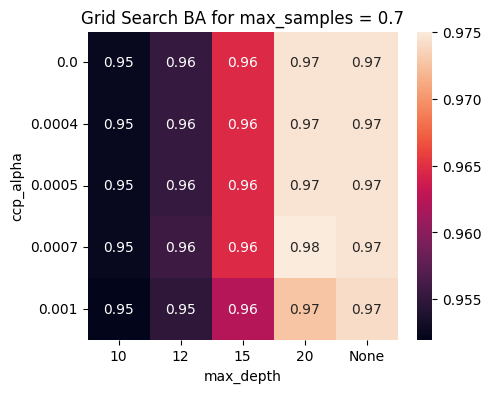

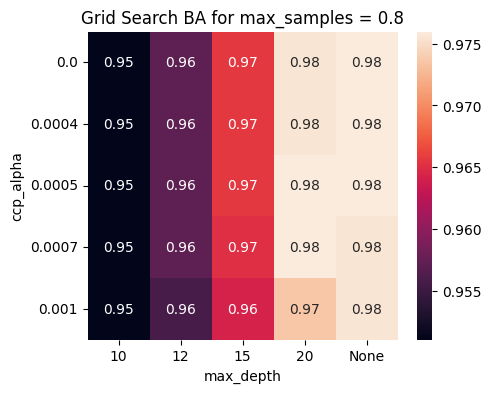

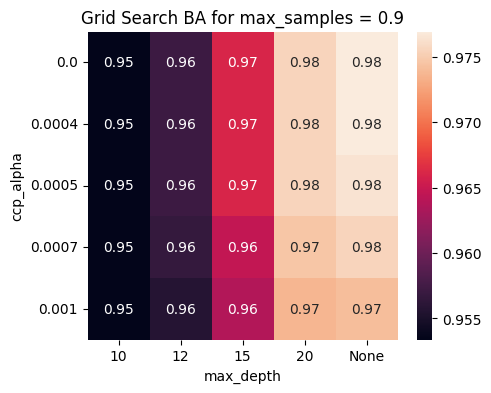

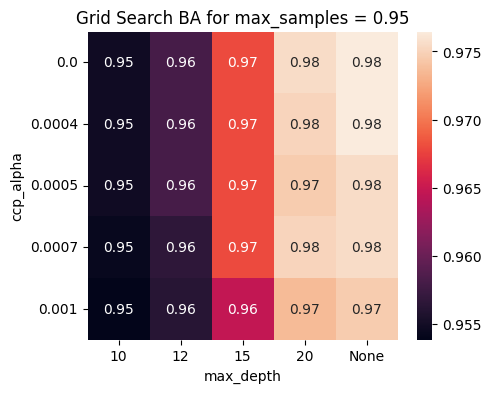

In [ ]:
hyperparam_x = 'max_depth'
hyperparam_y = 'ccp_alpha'
hyperparam_z = 'max_samples'

cv_scores_mat = cv_scores.reshape(len(param_grid[hyperparam_y]),
                                 len(param_grid[hyperparam_x]),
                                 len(param_grid[hyperparam_z]))

for i in range(cv_scores_mat.shape[2]):
    cv_scores_df = pd.DataFrame(cv_scores_mat[:,:,i],
                                columns=[x if x else 'None' for x in param_grid[hyperparam_x]],
                                index=param_grid[hyperparam_y])
    _, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))
    sns.heatmap(cv_scores_df, annot=True, ax=ax)
    plt.title(f'Grid Search BA for max_samples = {param_grid[hyperparam_z][i]}')
    plt.xlabel(hyperparam_x)
    plt.ylabel(hyperparam_y)
    ax.tick_params(axis='y', rotation=0)
    plt.show()